In [ ]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy import ndimage
from skimage.color import rgb2gray

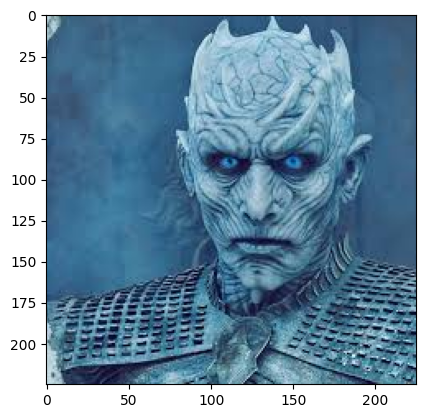

In [ ]:
img = io.imread("/content/nking.jpeg")
plt.imshow(img)
plt.show()

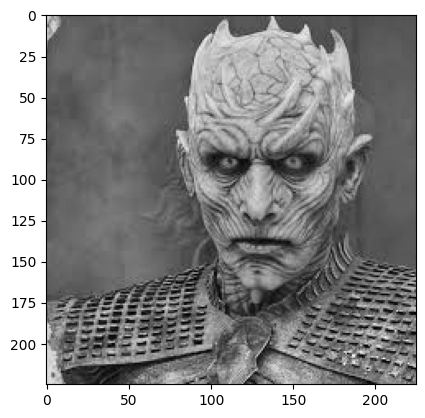

In [ ]:
gray_img = rgb2gray(img)
plt.imshow(gray_img, cmap = plt.get_cmap('gray'))
plt.show()

In [ ]:
import numpy as np

def gaussian_kernel(size, sigma = 1, verbose = True):
    size = int(size)//2
    x,y = np.mgrid[-size:size+1, -size:size+1]
    if verbose:
      print(x)
      print(y)

    normal = 1/(2.0*np.pi*sigma**2)
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))*normal
    return g

In [ ]:
gaussian_kernel(size = 3,sigma = 3)

[[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]
[[-1  0  1]
 [-1  0  1]
 [-1  0  1]]


array([[0.01582423, 0.01672824, 0.01582423],
       [0.01672824, 0.01768388, 0.01672824],
       [0.01582423, 0.01672824, 0.01582423]])

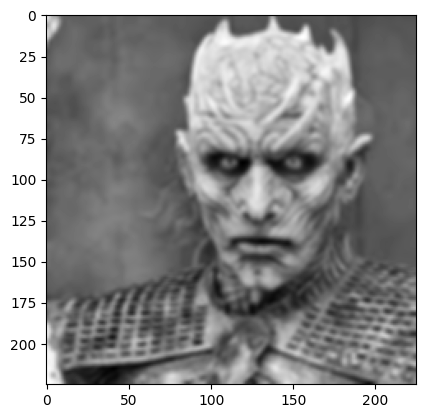

In [ ]:
noise_reducted_guassian_img = ndimage.convolve(gray_img, gaussian_kernel(size = 5, sigma = 1.4, verbose = False))
plt.imshow(noise_reducted_guassian_img, cmap = plt.get_cmap('gray'))
plt.show()

In [ ]:
from scipy import ndimage

def sobel_filters(img, verbose):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = ndimage.convolve(img, Kx)
    Iy = ndimage.convolve(img, Ky)

    # plotting x direction gradient changes and y direction gradient changes
    if verbose:
        print("Plotting X direction Changes")
        plt.imshow(Ix, cmap = plt.get_cmap('gray'))
        plt.show()
        print("Plotting Y direction Changes")
        plt.imshow(Iy, cmap = plt.get_cmap('gray'))
        plt.show()

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return (G, theta)

Plotting X direction Changes


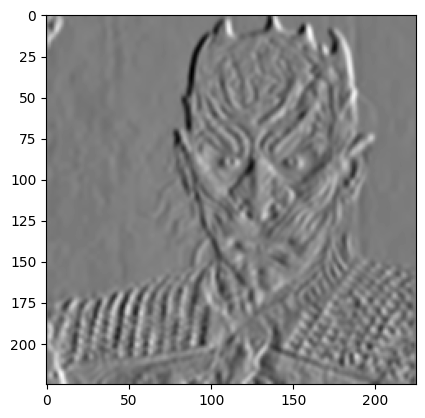

Plotting Y direction Changes


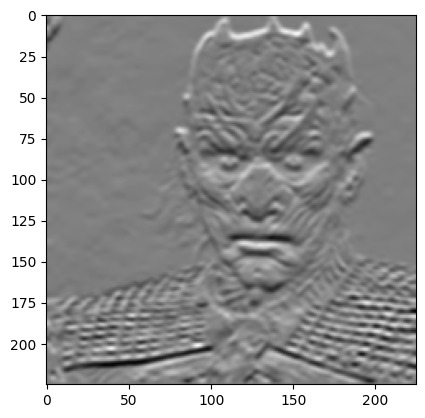

Plotting Gradient Magnitude Matrix


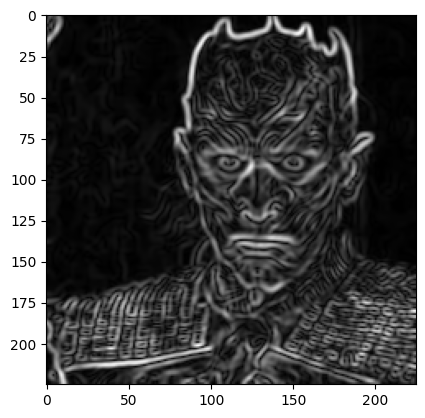

Plotting Gradient Theta Matrix


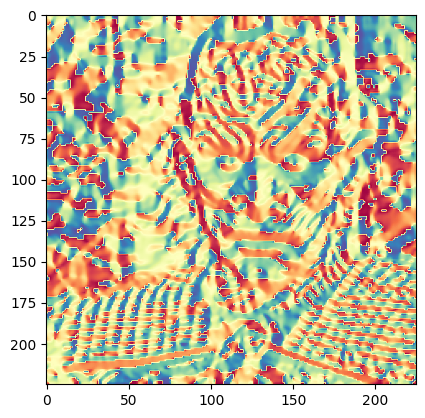

In [ ]:
g_mag_img, g_theta_img = sobel_filters(noise_reducted_guassian_img, verbose=True)
print("Plotting Gradient Magnitude Matrix")
plt.imshow(g_mag_img, cmap = plt.get_cmap('gray'))
plt.show()
print("Plotting Gradient Theta Matrix")
plt.imshow(g_theta_img, cmap = plt.get_cmap('Spectral'))
plt.show()

In [ ]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 255
                r = 255

                # angle 0
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                # angle 45
                elif (22.5 <= angle[i, j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                # angle 90
                elif (67.5 <= angle[i, j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                # angle 135
                elif (112.5 <= angle[i, j] < 157.5):
                    q = img[i+1, j+1]
                    r = img[i-1, j-1]

                if (img[i, j] >= q) and (img[i, j] >= r):
                    Z[i, j] = img[i, j]
                else:
                    Z[i, j] = 0

            except IndexError as e:
                pass

    return Z

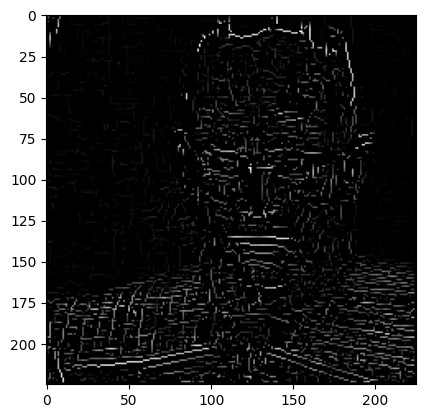

In [ ]:
img_res = non_max_suppression(g_mag_img, g_theta_img)
plt.imshow(img_nms, cmap = plt.get_cmap('gray'))
plt.show()

In [ ]:
img_nms

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.34020323, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.2690057 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.16051672, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05978646, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
def threshold(img, lowThresholdRatio = 0.05, highThresholdRatio = 0.09 , verbose = True):
  highThreshold = img.max()* highThresholdRatio
  lowThreshold = lowThresholdRatio* highThreshold

  if verbose:
    print(f"Max pixel Value is: {img.max()}")
    print(f"Strong edges Threshold is: > = {highThreshold}")
    print(f"Weak edges Thresolf is : > ={lowThreshold} and <={highThreshold} ")
    print(f"Discarded edges threshold is: < {lowThreshold}")

  M,N = img.shape
  res = np.zeros((M,N), dtype = np.int32)

  weak = np.int32(25)
  strong = np.int32(255)

  strong_i, strong_j = np.where(img>= highThreshold)
  zeros_i,zeros_j = np.where(img<lowThreshold)

  weak_i, weak_j = np.where((img<=highThreshold)&(img>= lowThreshold))

  res[strong_i, strong_j] = strong
  res[weak_i,weak_j]= weak

  return (res,weak,strong)


Max pixel Value is: 1.0
Strong edges Threshold is: > = 0.3
Weak edges Thresolf is : > =0.015 and <=0.3 
Discarded edges threshold is: < 0.015


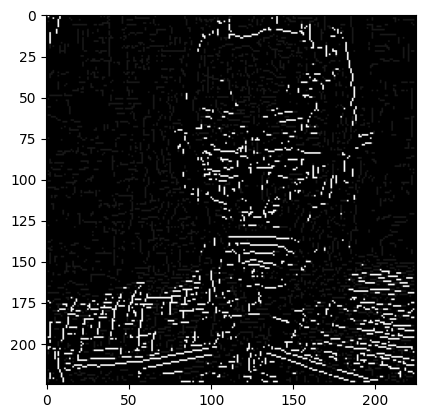

In [ ]:
canny_thresh, weak, strong = threshold(img_nms, 0.05, 0.30, True)
plt.imshow(canny_thresh , cmap = plt.get_cmap('gray'))
#plt.show()

In [ ]:
canny_thresh

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 255,   0, ...,   0,   0,   0],
       [  0,  25,   0, ...,   0,   0,   0],
       ...,
       [  0,  25,   0, ...,   0,   0,   0],
       [  0,  25,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [ ]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):

              if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                  or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                  or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                  img[i, j] = strong
              else:
                  img[i, j] = 0

    return img

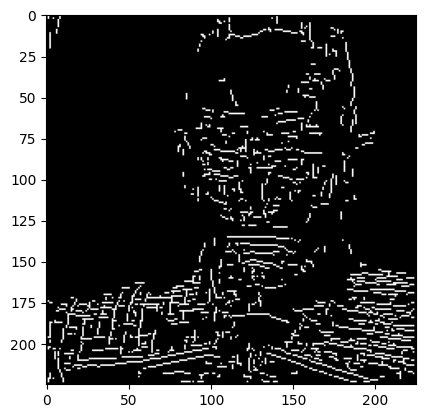

In [ ]:
canny_final = hysteresis(canny_thresh, weak, strong)
plt.imshow(canny_final, cmap = plt.get_cmap('gray'))
plt.show()

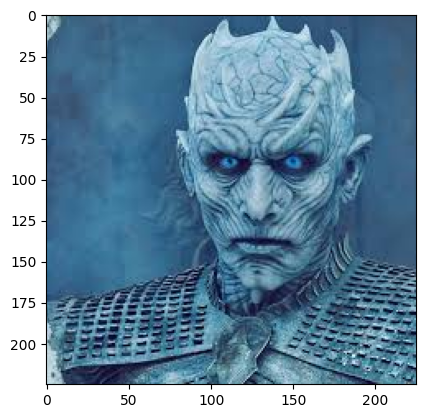

Ouput Image


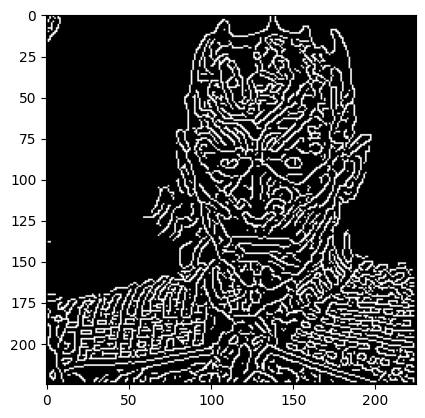

In [ ]:
img = io.imread("/content/nking.jpeg")
plt.imshow(img)
plt.show()

noise_reducted_guassian_img = ndimage.convolve(gray_img, gaussian_kernel(size = 5,sigma =1.4, verbose =False))
g_mag_img, g_theta_img = sobel_filters(noise_reducted_guassian_img, verbose = False)
img_nms = non_max_suppression(g_mag_img, g_theta_img)
canny_thresh, weak, strong = threshold(img_nms, 0.05, 0.11, False)
canny_final = hysteresis(canny_thresh, weak, strong)

print("Ouput Image")
plt.imshow(canny_final, cmap = plt.get_cmap('gray'))
plt.show()